<a href="https://colab.research.google.com/github/ParthKulkarni445/SigmaStox/blob/main/Portfolio_Implied_Volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Utilities**

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
import warnings
from scipy.stats import pearsonr
from itertools import combinations
import pickle
import os
from datetime import datetime

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class StockDataset(Dataset):
    """Custom Dataset class for stock price sequences"""
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.FloatTensor([self.targets[idx]])

class PortfolioDataset(Dataset):
    """Dataset for portfolio-level predictions"""
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx]), torch.FloatTensor([self.targets[idx]])

def calculate_realized_volatility(prices, window=20):
    """Calculate realized volatility using rolling window"""
    returns = np.log(prices / prices.shift(1)).dropna()
    realized_vol = returns.rolling(window=window).std() * np.sqrt(252)  # Annualized
    return realized_vol

def create_stock_features(data, lookback_window=60):
    """Create features from individual stock data, focusing on volatility"""
    data['Realized_Vol'] = calculate_realized_volatility(data['Close'])
    data['Vol_MA'] = data['Realized_Vol'].rolling(window=10).mean()

    feature_columns = [
        'Close',
        'Realized_Vol',
        'Vol_MA'
    ]

    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.fillna(method='ffill').fillna(method='bfill')

    data['Target_IV'] = data['Realized_Vol'].shift(-5)  # 5-day ahead volatility

    # Ensure only the selected feature columns and Target_IV are returned
    return data[feature_columns + ['Target_IV']].dropna()


def prepare_stock_sequences(data, sequence_length=60):
    """Prepare sequences for LSTM training"""
    feature_columns = [col for col in data.columns if col != 'Target_IV']

    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    scaled_features = feature_scaler.fit_transform(data[feature_columns])
    scaled_targets = target_scaler.fit_transform(data[['Target_IV']])

    sequences = []
    targets = []

    for i in range(sequence_length, len(scaled_features)):
        sequences.append(scaled_features[i-sequence_length:i])
        targets.append(scaled_targets[i, 0])

    return np.array(sequences), np.array(targets), feature_scaler, target_scaler

def save_model(model, filepath, scalers=None, metadata=None):
    """Save model with scalers and metadata"""
    save_dict = {
        'model_state_dict': model.state_dict(),
        'model_class': model.__class__.__name__,
        'scalers': scalers,
        'metadata': metadata,
        'timestamp': datetime.now().isoformat()
    }

    torch.save(save_dict, filepath)
    print(f"Model saved to {filepath}")

def load_model(filepath, model_class):
    """Load model with scalers and metadata"""
    checkpoint = torch.load(filepath)

    # You'll need to instantiate the model with the correct parameters
    # This is a simplified version - you might need to save model parameters too
    model = model_class()
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, checkpoint.get('scalers'), checkpoint.get('metadata')

# **Stage I : Stock IV Forecasting**

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import optuna
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

class LSTMModel(nn.Module):
    """LSTM Model for Individual Stock IV Prediction"""
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout_rate if num_layers > 1 else 0,
            batch_first=True
        )

        self.batch_norm = nn.BatchNorm1d(hidden_size)

        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, 1)

        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        lstm_out, _ = self.lstm(x, (h0, c0))

        last_output = lstm_out[:, -1, :]

        normalized = self.batch_norm(last_output)

        out = self.relu(self.fc1(normalized))
        out = self.dropout(out)
        out = self.fc2(out)

        return out

def train_lstm_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """Train individual stock LSTM model"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 20

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    return train_losses, val_losses, best_val_loss

def optimize_lstm_hyperparameters(X_train, y_train, X_val, y_val, input_size, device, n_trials=50):
    """Optimize LSTM hyperparameters using Optuna"""

    def objective(trial):
        hidden_size = trial.suggest_categorical('hidden_size', [32, 48])
        num_layers = trial.suggest_int('num_layers', 1, 2)
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 48])

        model = LSTMModel(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout_rate=dropout_rate
        ).to(device)

        train_dataset = StockDataset(X_train, y_train)
        val_dataset = StockDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        _, _, best_val_loss = train_lstm_model(
            model, train_loader, val_loader, 50, learning_rate, device
        )

        return best_val_loss

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("Best hyperparameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")

    return study.best_params

# **Portfolio Features**

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def calculate_correlation_matrix(returns_data, window=60):
    """Calculate rolling correlation matrix between stocks"""
    correlations = []
    correlation_dates = []

    for i in range(window, len(returns_data)):
        window_data = returns_data.iloc[i-window:i]
        corr_matrix = window_data.corr().values
        corr_matrix = np.nan_to_num(corr_matrix)
        correlations.append(corr_matrix)
        correlation_dates.append(returns_data.index[i])

    return np.array(correlations), correlation_dates

def create_portfolio_features(individual_ivs, weights, correlations, correlation_dates):
    """
    Create portfolio-level features for Stage II
    Args:
        individual_ivs: Dict of individual stock IV predictions
        weights: Portfolio weights for each stock
        correlations: Correlation matrices over time
        correlation_dates: Dates corresponding to correlation matrices
    """
    features = []
    feature_dates = []

    aligned_dates = None
    for ticker, iv_series in individual_ivs.items():
        if aligned_dates is None:
            aligned_dates = iv_series.index
        else:
            aligned_dates = aligned_dates.intersection(iv_series.index)

    aligned_dates = aligned_dates.sort_values()
    correlation_dates_index = pd.Index(correlation_dates)

    common_dates = aligned_dates.intersection(correlation_dates_index)

    for date in common_dates:
        feature_vector = []

        stock_ivs = []
        for ticker in individual_ivs.keys():
            if date in individual_ivs[ticker].index:
                stock_ivs.append(individual_ivs[ticker].loc[date])
            else:
                if not individual_ivs[ticker].empty:
                    stock_ivs.append(individual_ivs[ticker].iloc[-1])
                else:
                    stock_ivs.append(0)

        feature_vector.extend(stock_ivs)

        feature_vector.extend(weights[:len(stock_ivs)])

        if date in correlation_dates_index:
            corr_index = correlation_dates_index.get_loc(date)
            corr_matrix = correlations[corr_index]

            if corr_matrix.shape[0] == len(stock_ivs):
                upper_tri_indices = np.triu_indices_from(corr_matrix, k=1)
                if len(upper_tri_indices[0]) > 0:
                    avg_correlation = np.mean(corr_matrix[upper_tri_indices])
                    max_correlation = np.max(corr_matrix[upper_tri_indices])
                    min_correlation = np.min(corr_matrix[upper_tri_indices])
                    feature_vector.extend([avg_correlation, max_correlation, min_correlation])
                else:
                    feature_vector.extend([0, 0, 0])
            else:
                feature_vector.extend([np.nan, np.nan, np.nan])
        else:
            feature_vector.extend([np.nan, np.nan, np.nan])


        if len(stock_ivs) == len(weights[:len(stock_ivs)]):
            weighted_iv = np.sum(np.array(stock_ivs) * np.array(weights[:len(stock_ivs)]))
            iv_dispersion = np.std(stock_ivs) if len(stock_ivs) > 1 else 0
            feature_vector.extend([weighted_iv, iv_dispersion])
        else:
            feature_vector.extend([np.nan, np.nan])

        features.append(feature_vector)
        feature_dates.append(date)

    features_df = pd.DataFrame(features, index=feature_dates)
    features_df = features_df.fillna(0)

    return features_df.values, features_df.index

def calculate_portfolio_iv_target(individual_ivs, weights, correlations, correlation_dates):
    """
    Calculate target portfolio IV using correlation-adjusted formula
    Portfolio Variance = w^T * Σ * w
    where Σ is the covariance matrix
    """
    targets = []
    target_dates = []

    aligned_dates = None
    for ticker, iv_series in individual_ivs.items():
        if aligned_dates is None:
            aligned_dates = iv_series.index
        else:
            aligned_dates = aligned_dates.intersection(iv_series.index)

    aligned_dates = aligned_dates.sort_values()
    correlation_dates_index = pd.Index(correlation_dates)
    common_dates = aligned_dates.intersection(correlation_dates_index)

    for date in common_dates:
        ivs = []
        for ticker in individual_ivs.keys():
            if date in individual_ivs[ticker].index:
                ivs.append(individual_ivs[ticker].loc[date])
            else:
                if not individual_ivs[ticker].empty:
                    ivs.append(individual_ivs[ticker].iloc[-1])
                else:
                    ivs.append(0)

        ivs = np.array(ivs)
        weights_array = np.array(weights[:len(ivs)])

        if date in correlation_dates_index:
            corr_index = correlation_dates_index.get_loc(date)
            corr_matrix = correlations[corr_index]

            if corr_matrix.shape[0] == len(ivs):
                cov_matrix = np.outer(ivs, ivs) * corr_matrix

                portfolio_var = np.dot(weights_array, np.dot(cov_matrix, weights_array))
                portfolio_iv = np.sqrt(max(portfolio_var, 0))

                targets.append(portfolio_iv)
                target_dates.append(date)

    return np.array(targets), target_dates

# **Stage 2 : Portfolio IV Prediction**

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler # Added StandardScaler import

class PortfolioMLPModel(nn.Module):
    """
    Multi-Layer Perceptron for Portfolio IV Prediction
    Input Features:
    - Individual stock IV predictions
    - Portfolio weights
    - Pairwise correlations
    - Market regime indicators
    """
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout_rate=0.3):
        super(PortfolioMLPModel, self).__init__()

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size

        # Add the final output layer to produce a single prediction
        layers.append(nn.Linear(prev_size, 1))


        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Removed PortfolioGNNModel class

def train_portfolio_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """Train portfolio-level model"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=15, factor=0.5)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 25

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    return train_losses, val_losses, best_val_loss

def optimize_mlp_hyperparameters(X_train, y_train, X_val, y_val, device, n_trials=30):
    """Optimize MLP hyperparameters using Optuna"""

    def objective(trial):
        hidden_sizes = []
        n_layers = trial.suggest_int('n_layers', 2, 5)

        for i in range(n_layers):
            hidden_size = trial.suggest_categorical(f'hidden_size_{i}', [32, 64, 128, 256, 512])
            hidden_sizes.append(hidden_size)

        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

        model = PortfolioMLPModel(
            input_size=X_train.shape[1],
            hidden_sizes=hidden_sizes,
            dropout_rate=dropout_rate
        ).to(device)

        train_dataset = PortfolioDataset(X_train, y_train)
        val_dataset = PortfolioDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        _, _, best_val_loss = train_portfolio_model(
            model, train_loader, val_loader, 100, learning_rate, device
        )

        return best_val_loss

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("Best MLP hyperparameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")

    return study.best_params

# **Plotting Utilities**

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

def plot_stage1_results(train_losses, val_losses, y_true, y_pred, ticker):
    """Plot Stage I (individual stock) results"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Stage I Results - {ticker}', fontsize=16)

    axes[0, 0].plot(train_losses, label='Training Loss', alpha=0.8)
    axes[0, 0].plot(val_losses, label='Validation Loss', alpha=0.8)
    axes[0, 0].set_title('Training History')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].scatter(y_true, y_pred, alpha=0.6)
    axes[0, 1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0, 1].set_xlabel('Actual IV')
    axes[0, 1].set_ylabel('Predicted IV')
    axes[0, 1].set_title('Actual vs Predicted')
    axes[0, 1].grid(True, alpha=0.3)

    axes[0, 2].plot(y_true[:200], label='Actual', alpha=0.8)
    axes[0, 2].plot(y_pred[:200], label='Predicted', alpha=0.8)
    axes[0, 2].set_title('Time Series (First 200 points)')
    axes[0, 2].set_xlabel('Time')
    axes[0, 2].set_ylabel('IV')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    residuals = y_true - y_pred
    axes[1, 0].scatter(y_pred, residuals, alpha=0.6)
    axes[1, 0].axhline(y=0, color='r', linestyle='--')
    axes[1, 0].set_xlabel('Predicted IV')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residuals Plot')
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Residuals')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Residuals Distribution')
    axes[1, 1].grid(True, alpha=0.3)

    axes[1, 2].plot(np.abs(residuals), alpha=0.7)
    axes[1, 2].set_xlabel('Time')
    axes[1, 2].set_ylabel('Absolute Error')
    axes[1, 2].set_title('Absolute Error Over Time')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_stage2_results(train_losses, val_losses, y_true, y_pred, model_name):
    """Plot Stage II (portfolio) results"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Stage II Results - {model_name}', fontsize=16)

    axes[0, 0].plot(train_losses, label='Training Loss', alpha=0.8)
    axes[0, 0].plot(val_losses, label='Validation Loss', alpha=0.8)
    axes[0, 0].set_title('Training History')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].scatter(y_true, y_pred, alpha=0.6)
    axes[0, 1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0, 1].set_xlabel('Actual Portfolio IV')
    axes[0, 1].set_ylabel('Predicted Portfolio IV')
    axes[0, 1].set_title('Actual vs Predicted')
    axes[0, 1].grid(True, alpha=0.3)

    axes[0, 2].plot(y_true, label='Actual', alpha=0.8)
    axes[0, 2].plot(y_pred, label='Predicted', alpha=0.8)
    axes[0, 2].set_title('Portfolio IV Time Series')
    axes[0, 2].set_xlabel('Time')
    axes[0, 2].set_ylabel('Portfolio IV')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    residuals = y_true - y_pred
    axes[1, 0].scatter(y_pred, residuals, alpha=0.6)
    axes[1, 0].axhline(y=0, color='r', linestyle='--')
    axes[1, 0].set_xlabel('Predicted Portfolio IV')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residuals Plot')
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Residuals')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Residuals Distribution')
    axes[1, 1].grid(True, alpha=0.3)

    correlation, p_value = pearsonr(y_true, y_pred)
    axes[1, 2].text(0.1, 0.9, f'Correlation: {correlation:.4f}', transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].text(0.1, 0.8, f'P-value: {p_value:.4f}', transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].text(0.1, 0.7, f'RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}', transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].text(0.1, 0.6, f'MAE: {mean_absolute_error(y_true, y_pred):.4f}', transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].set_title('Model Performance Metrics')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

def plot_portfolio_comparison(results_dict):
    """Compare different portfolio models"""
    models = list(results_dict.keys())
    metrics = ['RMSE', 'MAE', 'Correlation']

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, metric in enumerate(metrics):
        values = []
        for model in models:
            if metric == 'RMSE':
                values.append(results_dict[model]['rmse'])
            elif metric == 'MAE':
                values.append(results_dict[model]['mae'])
            elif metric == 'Correlation':
                values.append(results_dict[model]['correlation'])

        axes[i].bar(models, values, alpha=0.7)
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# **Stage I Exexcution**

Using device: cpu
STAGE I: INDIVIDUAL STOCK IV PREDICTION

Processing MSFT...


[*********************100%***********************]  1 of 1 completed
[I 2025-08-02 15:51:44,561] A new study created in memory with name: no-name-bf4af848-584f-405b-88a2-3613bac10ef2


Optimizing hyperparameters for MSFT...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.001601, Val Loss: 0.002556
Epoch [40/50], Train Loss: 0.001558, Val Loss: 0.000612
[I 2025-08-02 15:52:04,346] Trial 0 finished with value: 0.0005606994149275124 and parameters: {'hidden_size': 48, 'num_layers': 1, 'dropout_rate': 0.1412330042422359, 'learning_rate': 0.0022241998073004757, 'batch_size': 32}. Best is trial 0 with value: 0.0005606994149275124.
Epoch [20/50], Train Loss: 0.001746, Val Loss: 0.000625
Epoch [40/50], Train Loss: 0.001715, Val Loss: 0.000603
[I 2025-08-02 15:52:13,667] Trial 1 finished with value: 0.0005630374604758496 and parameters: {'hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.1402898262507577, 'learning_rate': 0.0013731998969240306, 'batch_size': 48}. Best is trial 0 with value: 0.0005606994149275124.
Epoch [20/50], Train Loss: 0.002070, Val Loss: 0.000813
Epoch [40/50], Train Loss: 0.001676, Val Loss: 0.001128
[I 2025-08-02 15:52:38,226] Trial 2 finished with value: 0.0006432772788684815 and parameters: {'hidden_size

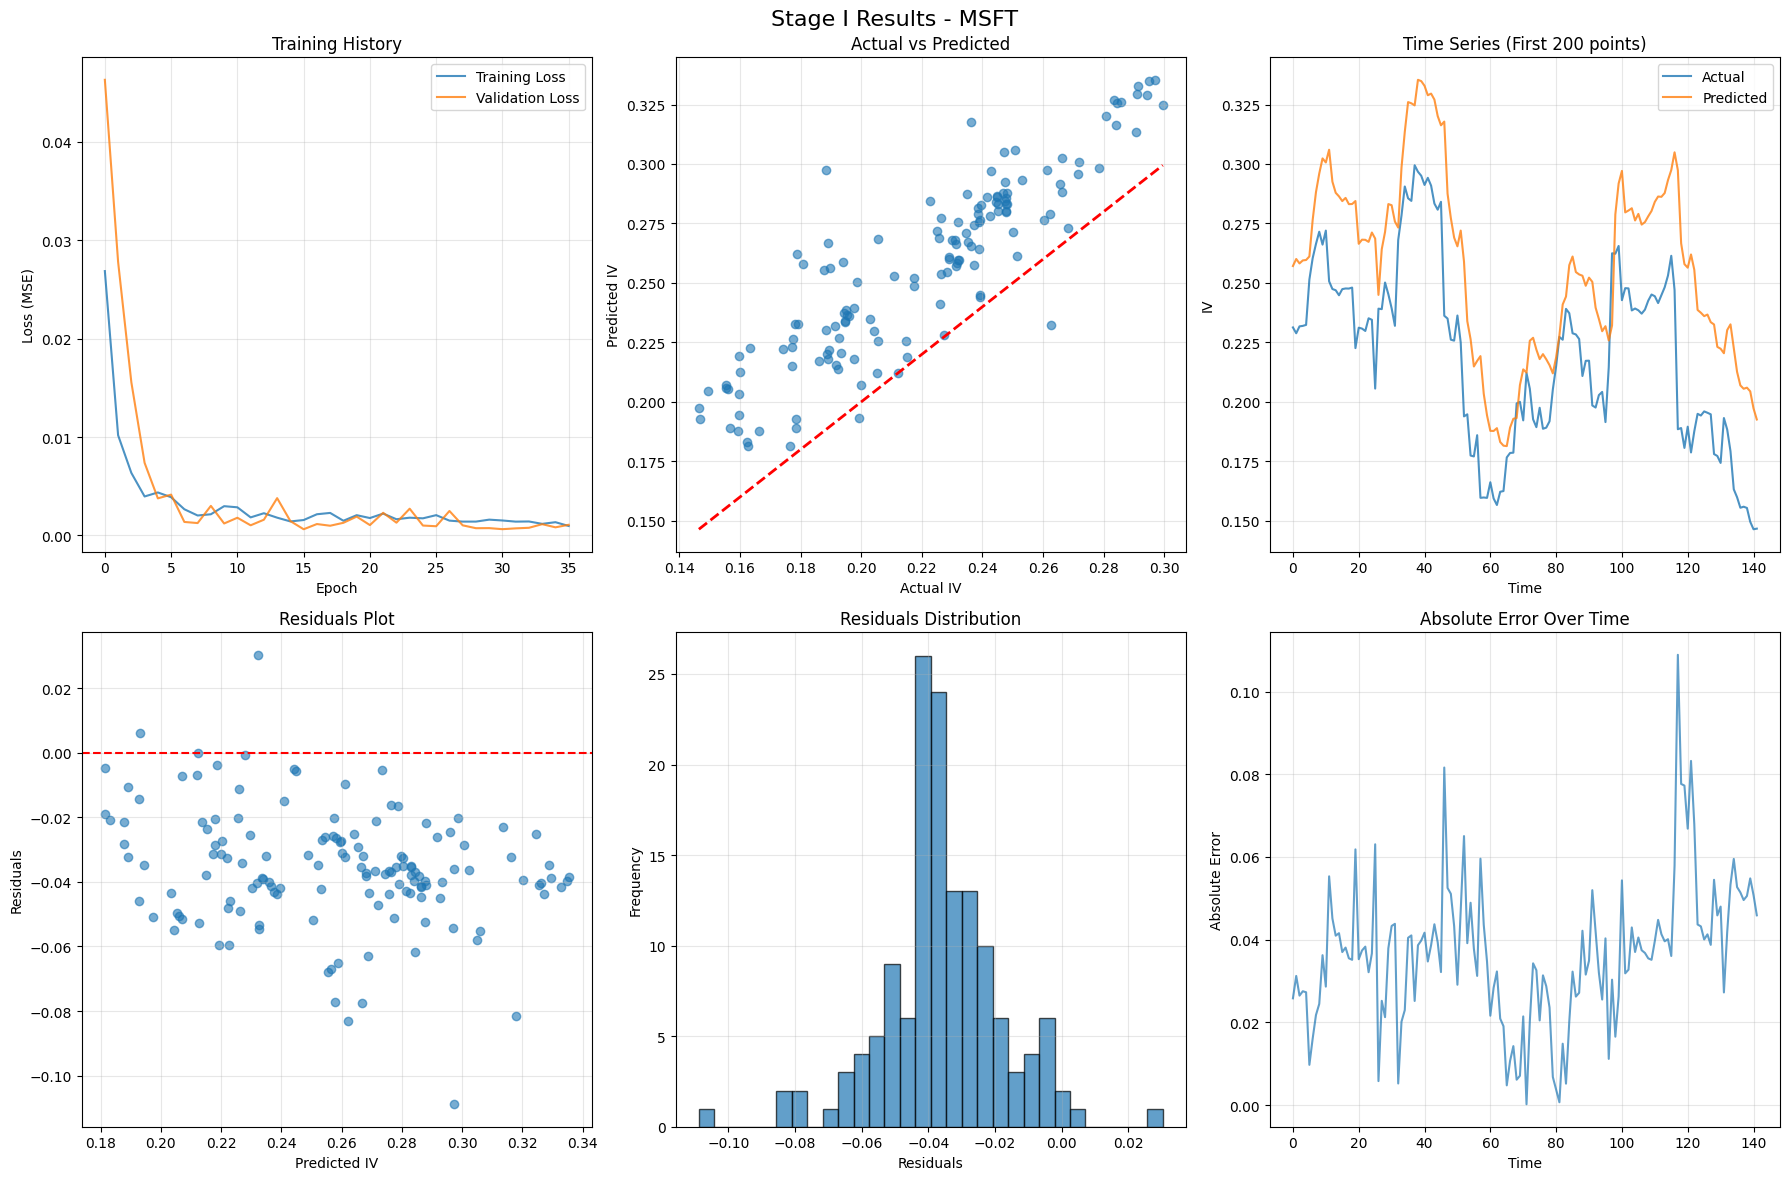


Processing NVDA...


[*********************100%***********************]  1 of 1 completed
[I 2025-08-02 15:53:44,956] A new study created in memory with name: no-name-2e4e2c61-81a2-4254-8262-30202933b305


Optimizing hyperparameters for NVDA...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.004892, Val Loss: 0.004292
Epoch [40/50], Train Loss: 0.004387, Val Loss: 0.002517
[I 2025-08-02 15:54:10,180] Trial 0 finished with value: 0.0025169176959833647 and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.36471678067555013, 'learning_rate': 0.004140199969957617, 'batch_size': 16}. Best is trial 0 with value: 0.0025169176959833647.
Epoch [20/50], Train Loss: 0.004845, Val Loss: 0.005423
Epoch [40/50], Train Loss: 0.004152, Val Loss: 0.003345
[I 2025-08-02 15:54:27,301] Trial 1 finished with value: 0.0033450349777316055 and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.39366257136880567, 'learning_rate': 0.001441107906889713, 'batch_size': 48}. Best is trial 0 with value: 0.0025169176959833647.
Epoch [20/50], Train Loss: 0.003432, Val Loss: 0.002930
[I 2025-08-02 15:54:41,738] Trial 2 finished with value: 0.0021324246610877 and parameters: {'hidden_size': 48, 'num_layers': 1, 'dropout_rate': 0.19100382444281855

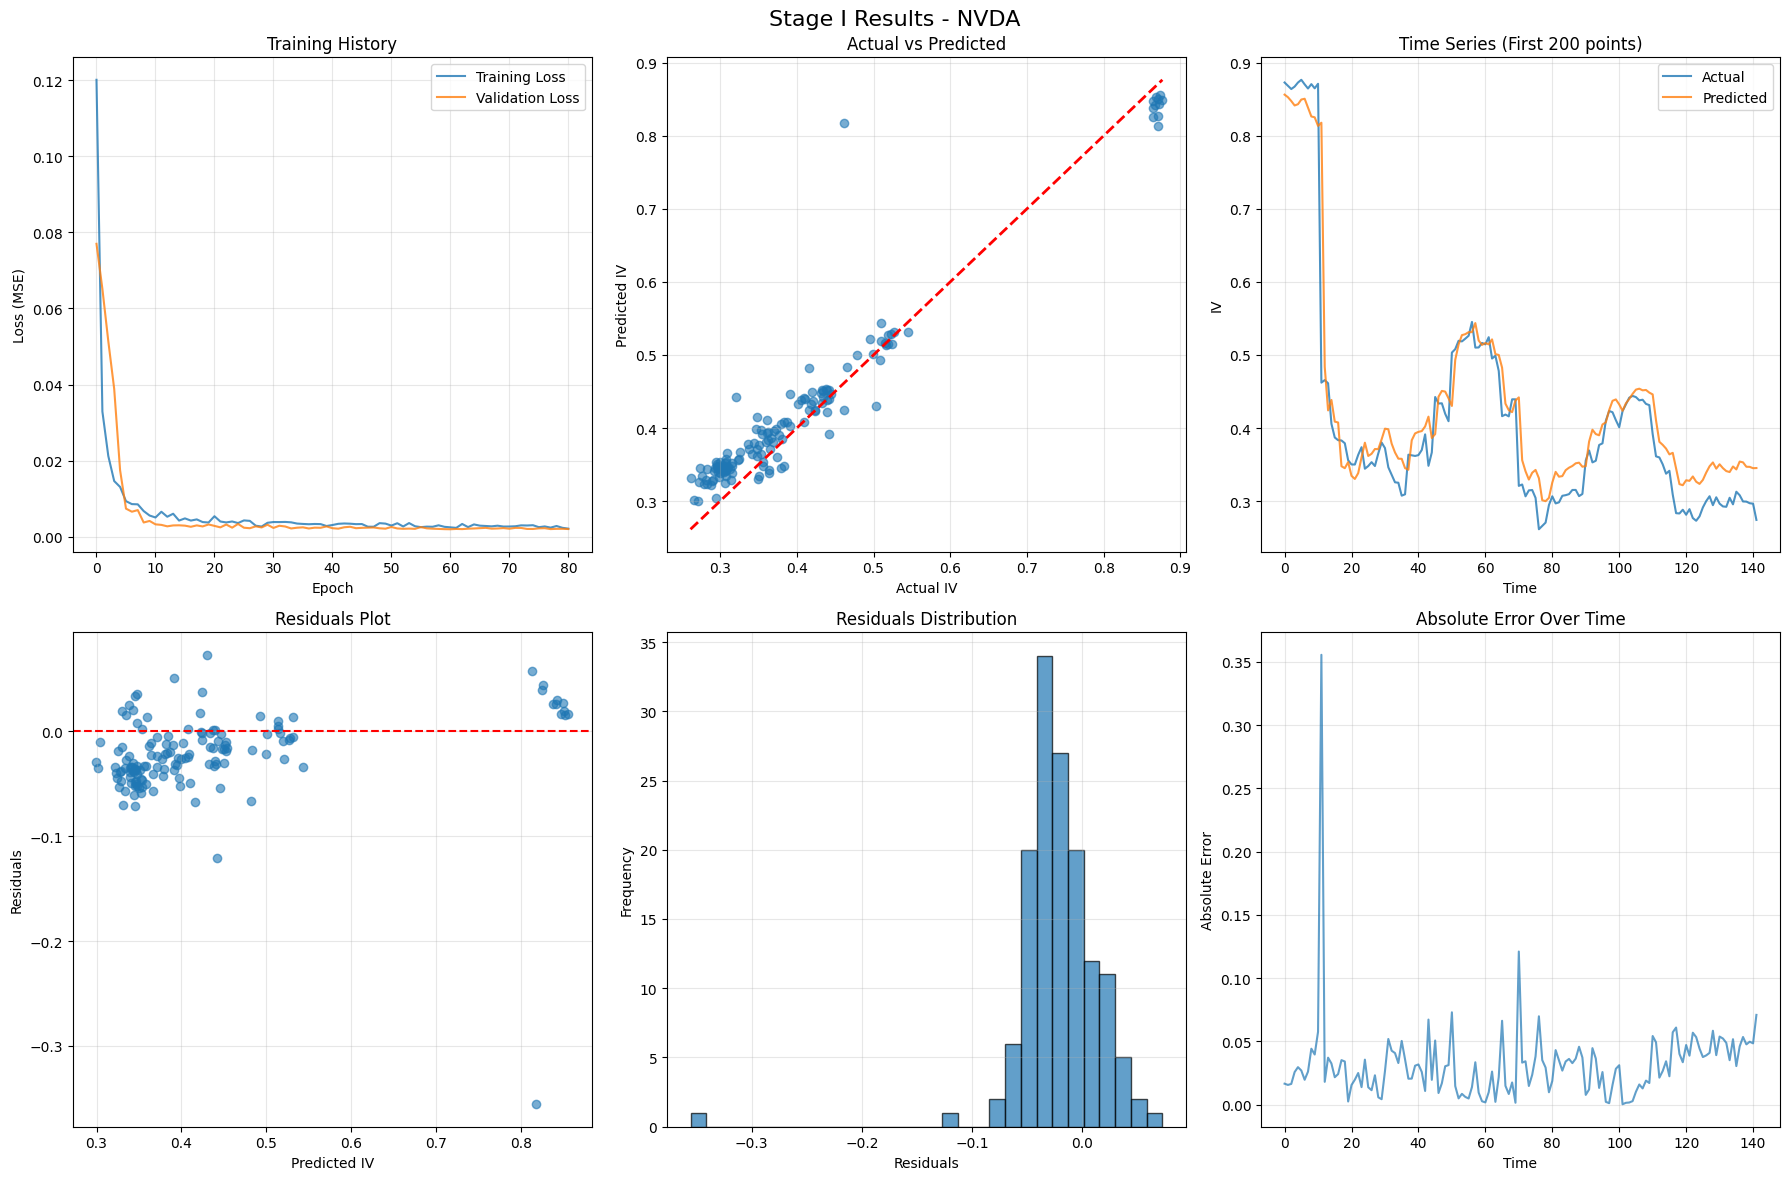


Processing AAPL...


[*********************100%***********************]  1 of 1 completed
[I 2025-08-02 15:55:52,693] A new study created in memory with name: no-name-e60fa733-8a91-44fe-9402-402554d83bf9


Optimizing hyperparameters for AAPL...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.002512, Val Loss: 0.001125
Epoch [40/50], Train Loss: 0.002284, Val Loss: 0.001030
[I 2025-08-02 15:56:09,049] Trial 0 finished with value: 0.00045264404131254804 and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.2561358869389393, 'learning_rate': 0.006475914028893159, 'batch_size': 48}. Best is trial 0 with value: 0.00045264404131254804.
Epoch [20/50], Train Loss: 0.002382, Val Loss: 0.000747
Epoch [40/50], Train Loss: 0.002227, Val Loss: 0.000438
[I 2025-08-02 15:56:21,744] Trial 1 finished with value: 0.00043437503336463124 and parameters: {'hidden_size': 48, 'num_layers': 1, 'dropout_rate': 0.4701088306626352, 'learning_rate': 0.0024691303459772203, 'batch_size': 48}. Best is trial 1 with value: 0.00043437503336463124.
Epoch [20/50], Train Loss: 0.002874, Val Loss: 0.000848
Epoch [40/50], Train Loss: 0.002555, Val Loss: 0.000964
[I 2025-08-02 15:56:42,241] Trial 2 finished with value: 0.0004967638582456857 and parameters: {'hidden_s

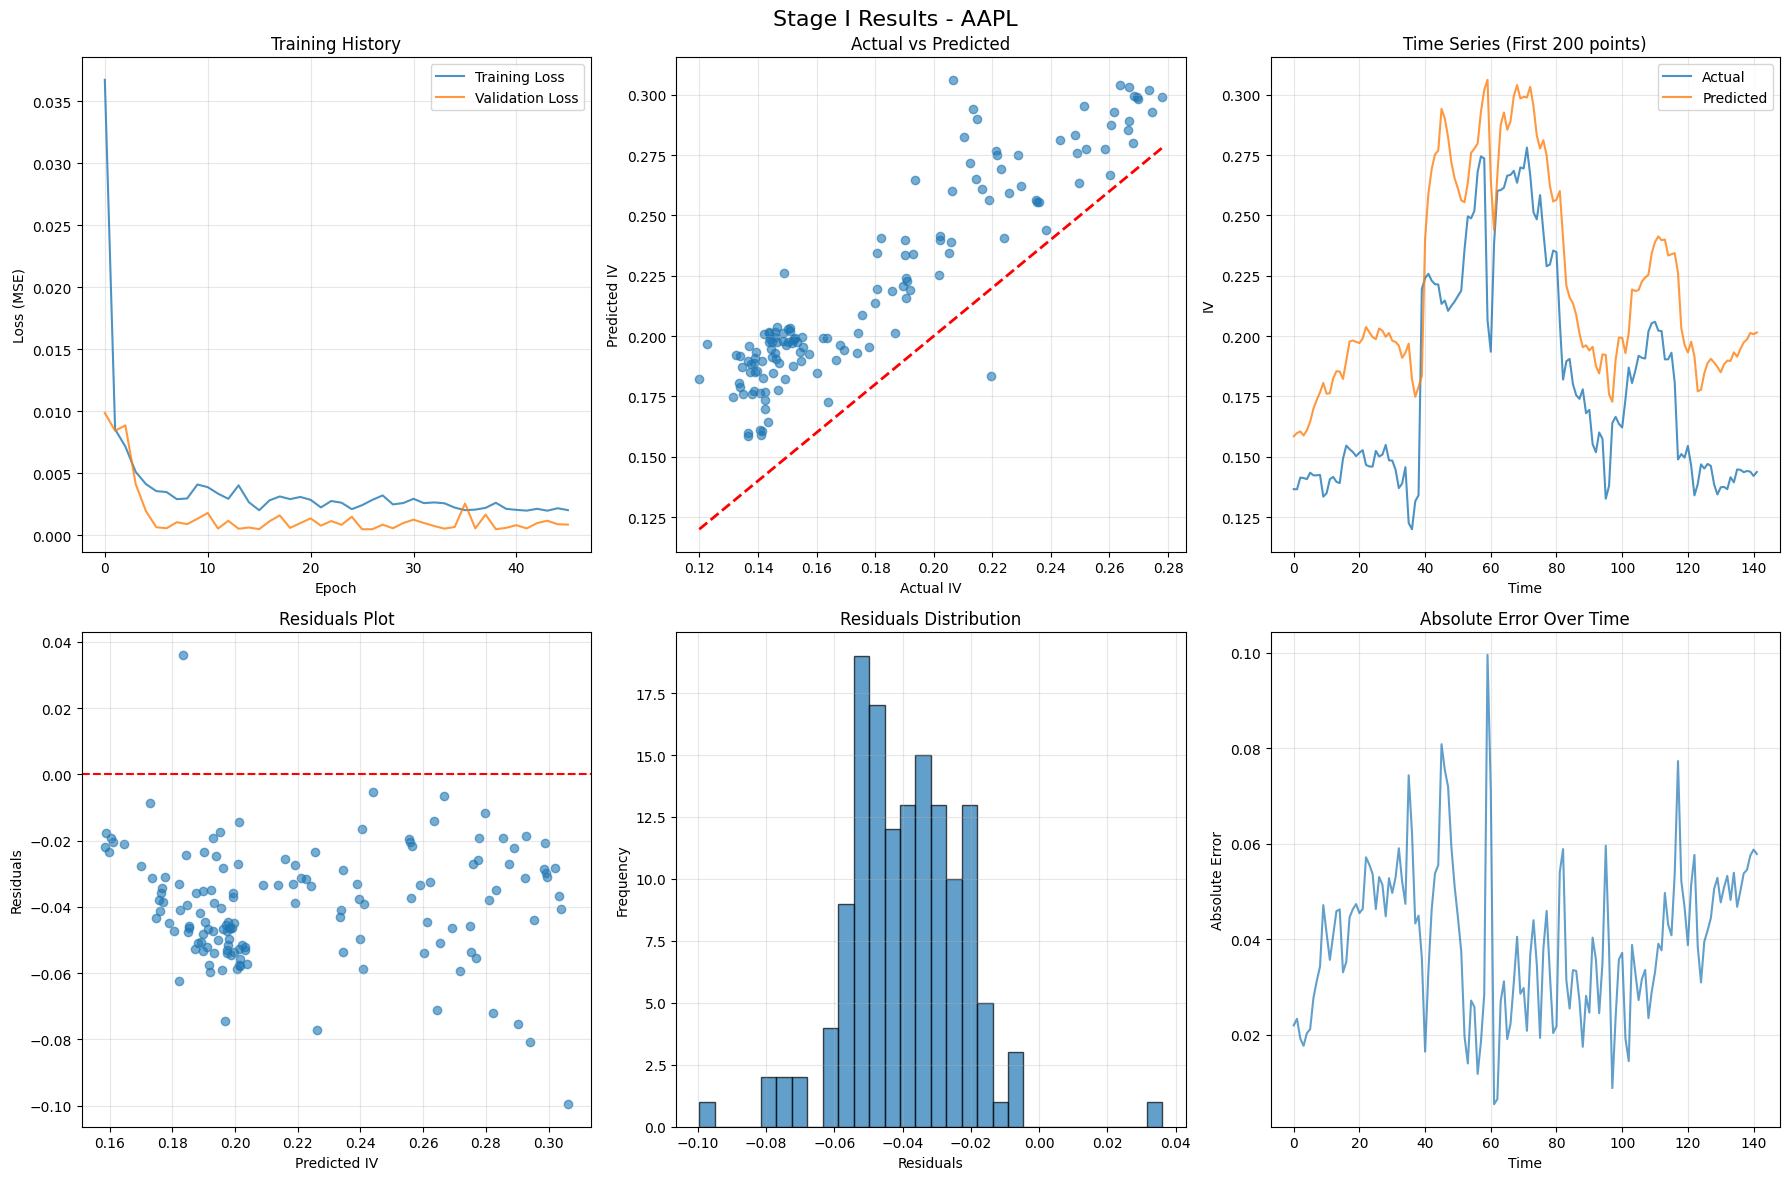

[*********************100%***********************]  1 of 1 completed


Processing AMZN...



[I 2025-08-02 15:57:52,519] A new study created in memory with name: no-name-4eb741e3-b08e-4112-b1a2-d5d59a32b2ba


Optimizing hyperparameters for AMZN...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.006095, Val Loss: 0.008647
Epoch [40/50], Train Loss: 0.005211, Val Loss: 0.005147
[I 2025-08-02 15:58:21,161] Trial 0 finished with value: 0.0019519442381958167 and parameters: {'hidden_size': 48, 'num_layers': 2, 'dropout_rate': 0.14644865546001112, 'learning_rate': 0.005553397649130584, 'batch_size': 48}. Best is trial 0 with value: 0.0019519442381958167.
Epoch [20/50], Train Loss: 0.006812, Val Loss: 0.003299
Epoch [40/50], Train Loss: 0.005260, Val Loss: 0.002114
[I 2025-08-02 15:58:35,088] Trial 1 finished with value: 0.001897569524589926 and parameters: {'hidden_size': 48, 'num_layers': 1, 'dropout_rate': 0.264882263186339, 'learning_rate': 0.0016353113658266365, 'batch_size': 32}. Best is trial 1 with value: 0.001897569524589926.
Epoch [20/50], Train Loss: 0.005903, Val Loss: 0.001836
[I 2025-08-02 15:58:43,967] Trial 2 finished with value: 0.001835545478388667 and parameters: {'hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.1692162950863076, 

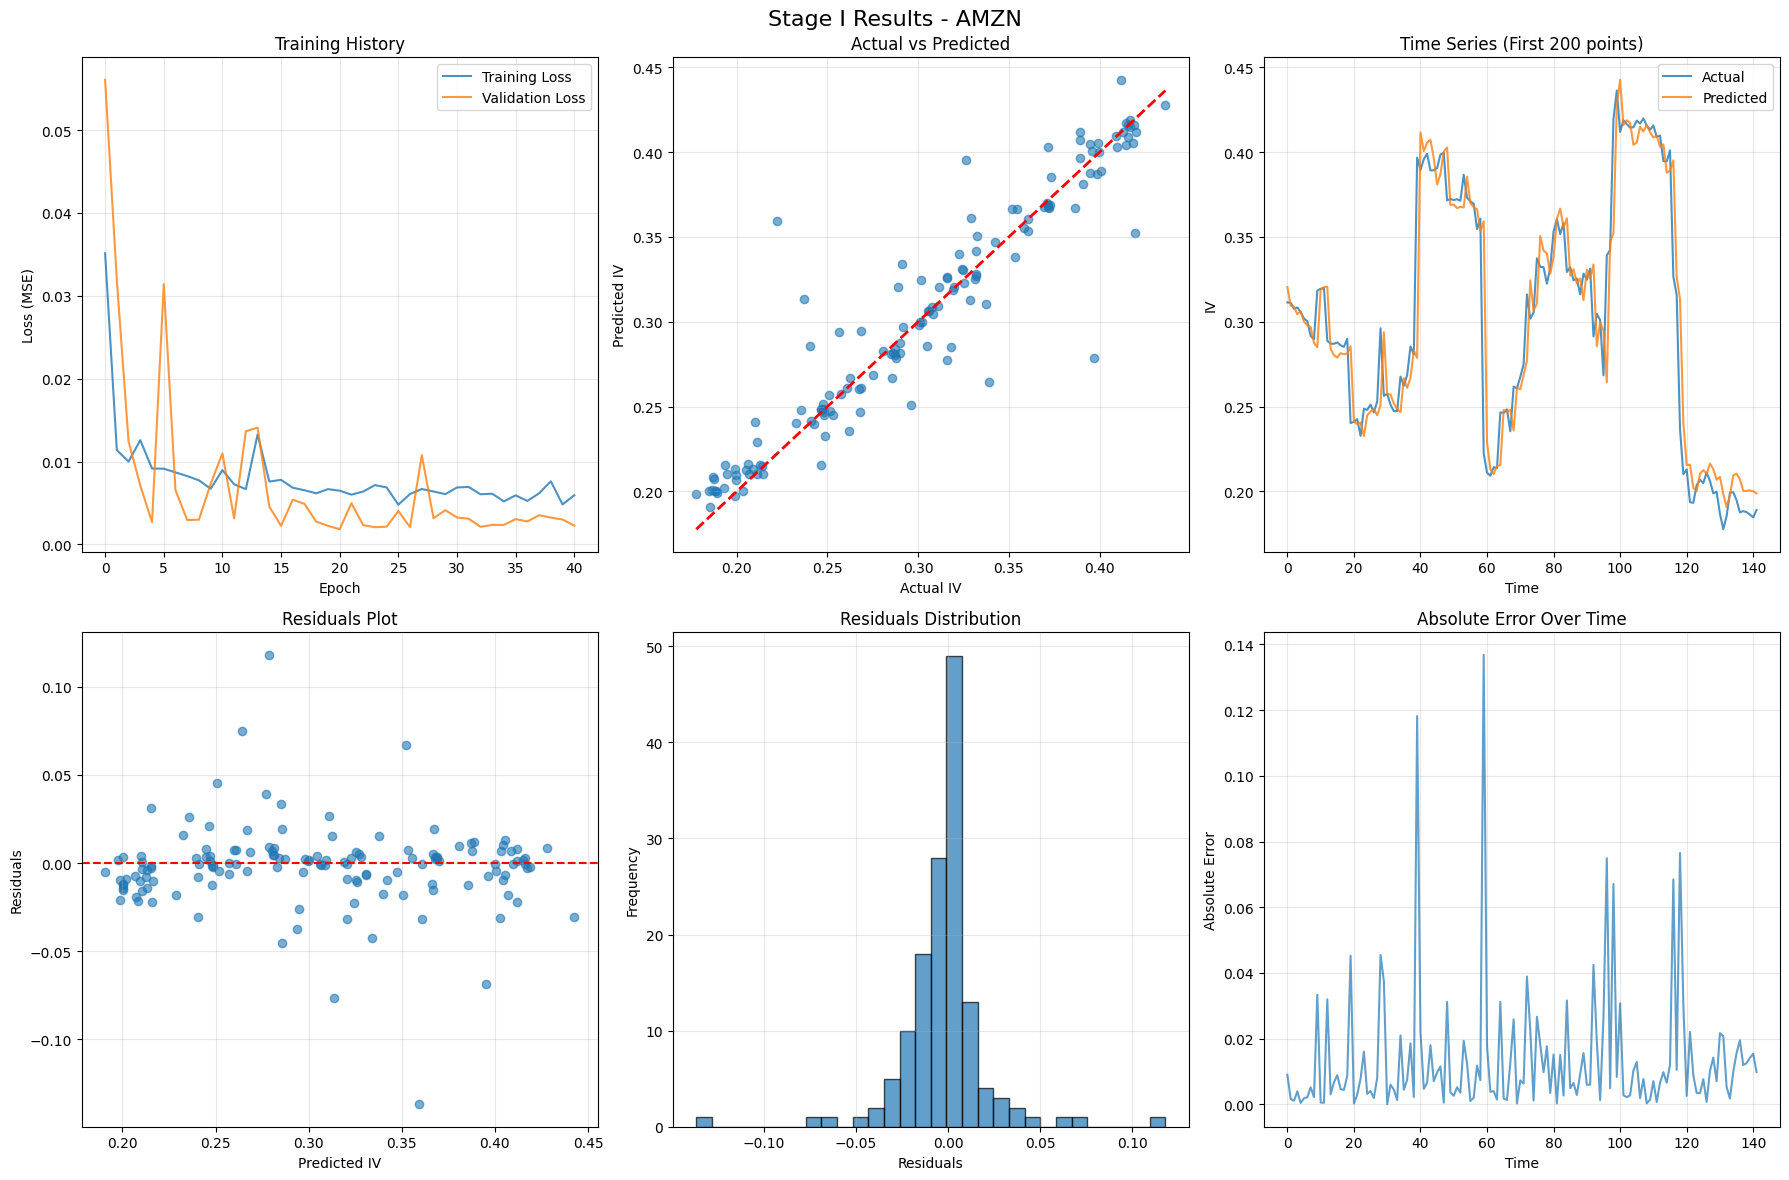

[*********************100%***********************]  1 of 1 completed


Processing GOOGL...



[I 2025-08-02 15:59:45,889] A new study created in memory with name: no-name-71ca2993-47a1-4a3c-b6a1-cf7c1ada24f2


Optimizing hyperparameters for GOOGL...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.003872, Val Loss: 0.001665
Epoch [40/50], Train Loss: 0.002711, Val Loss: 0.001147
[I 2025-08-02 16:00:02,281] Trial 0 finished with value: 0.001146553773044919 and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.1973745839949968, 'learning_rate': 0.004575942452490183, 'batch_size': 48}. Best is trial 0 with value: 0.001146553773044919.
Epoch [20/50], Train Loss: 0.003858, Val Loss: 0.001875
Epoch [40/50], Train Loss: 0.003255, Val Loss: 0.001316
[I 2025-08-02 16:00:19,680] Trial 1 finished with value: 0.0010601210912379126 and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.2362123285725507, 'learning_rate': 0.006519013694184079, 'batch_size': 48}. Best is trial 1 with value: 0.0010601210912379126.
Epoch [20/50], Train Loss: 0.004910, Val Loss: 0.002412
Epoch [40/50], Train Loss: 0.003780, Val Loss: 0.000947
[I 2025-08-02 16:00:38,828] Trial 2 finished with value: 0.000946882785582501 and parameters: {'hidden_size': 48

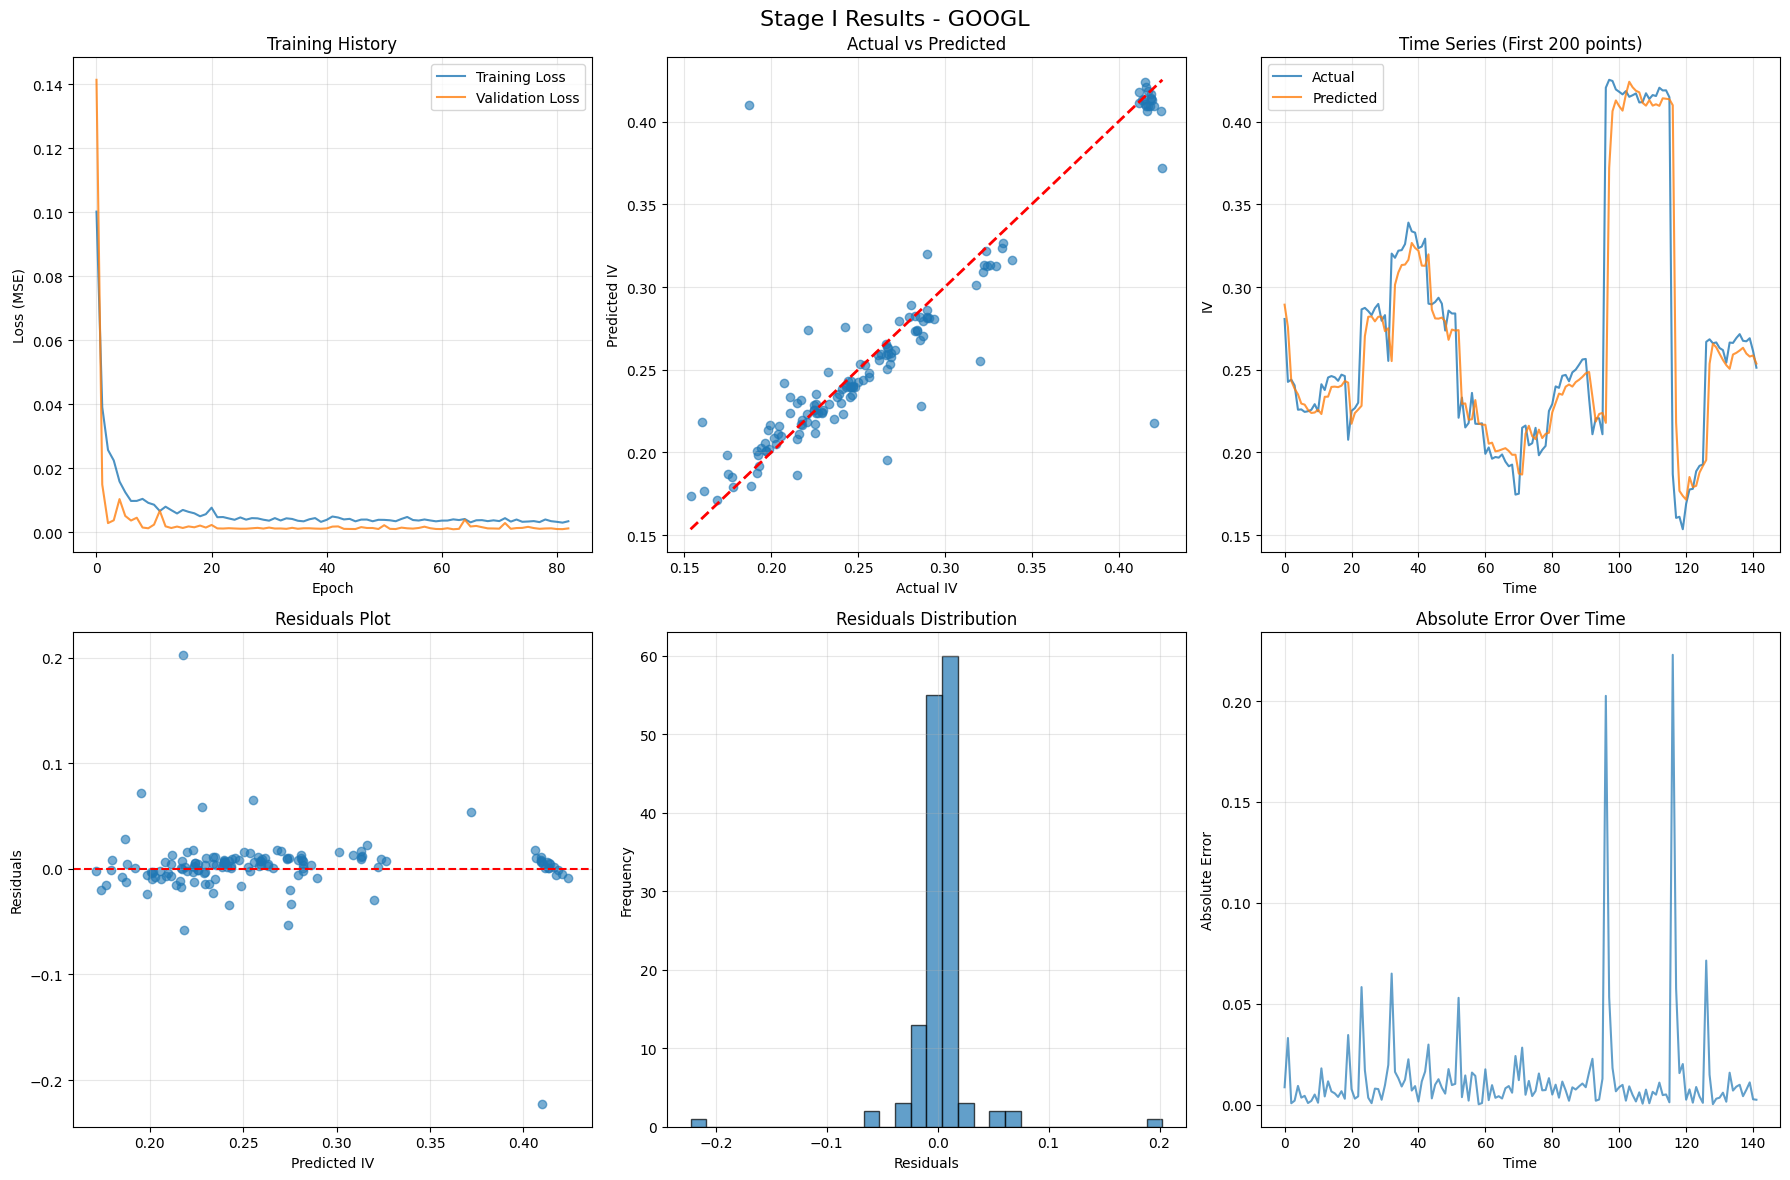


Stage I completed. Successfully processed 5 stocks.
Individual IV predictions available for: ['MSFT', 'NVDA', 'AAPL', 'AMZN', 'GOOGL']
Stage I results saved to 'results/stage1_results.pkl'


In [7]:
# Stage 1: Individual Stock IV Prediction
import sys
import os

# Configuration
tickers = [
    "MSFT", "NVDA", "AAPL", "AMZN", "GOOGL"
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories for saving models
os.makedirs('models/stage1', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("="*80)
print("STAGE I: INDIVIDUAL STOCK IV PREDICTION")
print("="*80)

stage1_results = {}
individual_iv_predictions = {}
stock_returns_data = {}

for ticker in tickers:
    print(f"\nProcessing {ticker}...")

    try:
        stock_data = yf.download(ticker, start='2020-01-01', end='2024-01-01')

        if len(stock_data) < 200:
            print(f"Insufficient data for {ticker}")
            continue

        returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1)).dropna()
        stock_returns_data[ticker] = returns

        processed_data = create_stock_features(stock_data)

        X, y, feature_scaler, target_scaler = prepare_stock_sequences(processed_data)

        train_size = int(0.7 * len(X))
        val_size = int(0.15 * len(X))

        X_train, y_train = X[:train_size], y[:train_size]
        X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
        X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

        input_size = X.shape[2]

        print(f"Optimizing hyperparameters for {ticker}...")
        best_params = optimize_lstm_hyperparameters(
            X_train, y_train, X_val, y_val, input_size, device, n_trials=6
        )

        best_model = LSTMModel(
            input_size=input_size,
            hidden_size=best_params['hidden_size'],
            num_layers=best_params['num_layers'],
            dropout_rate=best_params['dropout_rate']
        ).to(device)

        train_dataset = StockDataset(X_train, y_train)
        val_dataset = StockDataset(X_val, y_val)
        test_dataset = StockDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

        print(f"Training final model for {ticker}...")
        train_losses, val_losses, _ = train_lstm_model(
            best_model, train_loader, val_loader, 150, best_params['learning_rate'], device
        )

        model_path = f'models/stage1/{ticker}_best_model.pth'
        save_model(
            best_model,
            model_path,
            scalers=(feature_scaler, target_scaler),
            metadata={
                'ticker': ticker,
                'best_params': best_params,
                'input_size': input_size,
                'train_size': train_size,
                'val_size': val_size,
                'test_size': len(X_test)
            }
        )

        best_model.eval()
        all_predictions = []

        all_dataset = StockDataset(X, y)
        all_loader = DataLoader(all_dataset, batch_size=best_params['batch_size'], shuffle=False)

        with torch.no_grad():
            for sequences, _ in all_loader:
                sequences = sequences.to(device)
                outputs = best_model(sequences)
                all_predictions.extend(outputs.cpu().numpy())

        all_predictions = target_scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1)).flatten()

        prediction_dates = processed_data.index[60:]
        individual_iv_predictions[ticker] = pd.Series(all_predictions, index=prediction_dates[:len(all_predictions)])

        test_predictions = []
        test_actuals = []

        with torch.no_grad():
            for sequences, targets in test_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                outputs = best_model(sequences)
                test_predictions.extend(outputs.cpu().numpy())
                test_actuals.extend(targets.cpu().numpy())

        test_predictions = target_scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
        test_actuals = target_scaler.inverse_transform(np.array(test_actuals).reshape(-1, 1)).flatten()

        mse = mean_squared_error(test_actuals, test_predictions)
        mae = mean_absolute_error(test_actuals, test_predictions)
        rmse = np.sqrt(mse)

        print(f"Stage I Results for {ticker}:")
        print(f"MSE: {mse:.6f}, MAE: {mae:.6f}, RMSE: {rmse:.6f}")

        plot_stage1_results(train_losses, val_losses, test_actuals, test_predictions, ticker)

        stage1_results[ticker] = {
            'mse': mse, 'mae': mae, 'rmse': rmse,
            'model_path': model_path,
            'best_params': best_params,
            'scalers': (feature_scaler, target_scaler)
        }

    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        continue

print(f"\nStage I completed. Successfully processed {len(stage1_results)} stocks.")
print(f"Individual IV predictions available for: {list(individual_iv_predictions.keys())}")

with open('results/stage1_results.pkl', 'wb') as f:
    pickle.dump({
        'stage1_results': stage1_results,
        'individual_predictions': individual_iv_predictions,
        'stock_returns_data': stock_returns_data
    }, f)

print("Stage I results saved to 'results/stage1_results.pkl'")

# **Stage 2 Execution**

Loading Stage I results...
Using device: cpu

STAGE II: PORTFOLIO IV PREDICTION
Calculated 945 correlation matrices
Market data download and processing skipped as per requirements.
Creating portfolio features...
Calculating portfolio IV targets...


[I 2025-08-02 16:23:09,341] A new study created in memory with name: no-name-1b12e662-0458-4a7a-8ee8-24168658bcd9


Portfolio dataset size: 940 samples
Feature dimension: 15

Optimizing MLP hyperparameters...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 0.190542, Val Loss: 0.003151
Epoch [40/100], Train Loss: 0.179890, Val Loss: 0.002898
Epoch [60/100], Train Loss: 0.137721, Val Loss: 0.002966
Epoch [80/100], Train Loss: 0.124099, Val Loss: 0.003895
[I 2025-08-02 16:23:26,142] Trial 0 finished with value: 0.0021601743064820766 and parameters: {'n_layers': 5, 'hidden_size_0': 512, 'hidden_size_1': 64, 'hidden_size_2': 256, 'hidden_size_3': 512, 'hidden_size_4': 256, 'dropout_rate': 0.469509060076454, 'learning_rate': 2.4792279485273394e-05, 'batch_size': 32}. Best is trial 0 with value: 0.0021601743064820766.
Epoch [20/100], Train Loss: 0.013479, Val Loss: 0.008927
Epoch [40/100], Train Loss: 0.004775, Val Loss: 0.002477
Epoch [60/100], Train Loss: 0.004104, Val Loss: 0.002057
Epoch [80/100], Train Loss: 0.002778, Val Loss: 0.000731
Epoch [100/100], Train Loss: 0.002319, Val Loss: 0.000433
[I 2025-08-02 16:23:38,241] Trial 1 finished with value: 0.0001278277217756517 and parameters: {'n_layers': 2, 'hidden_s

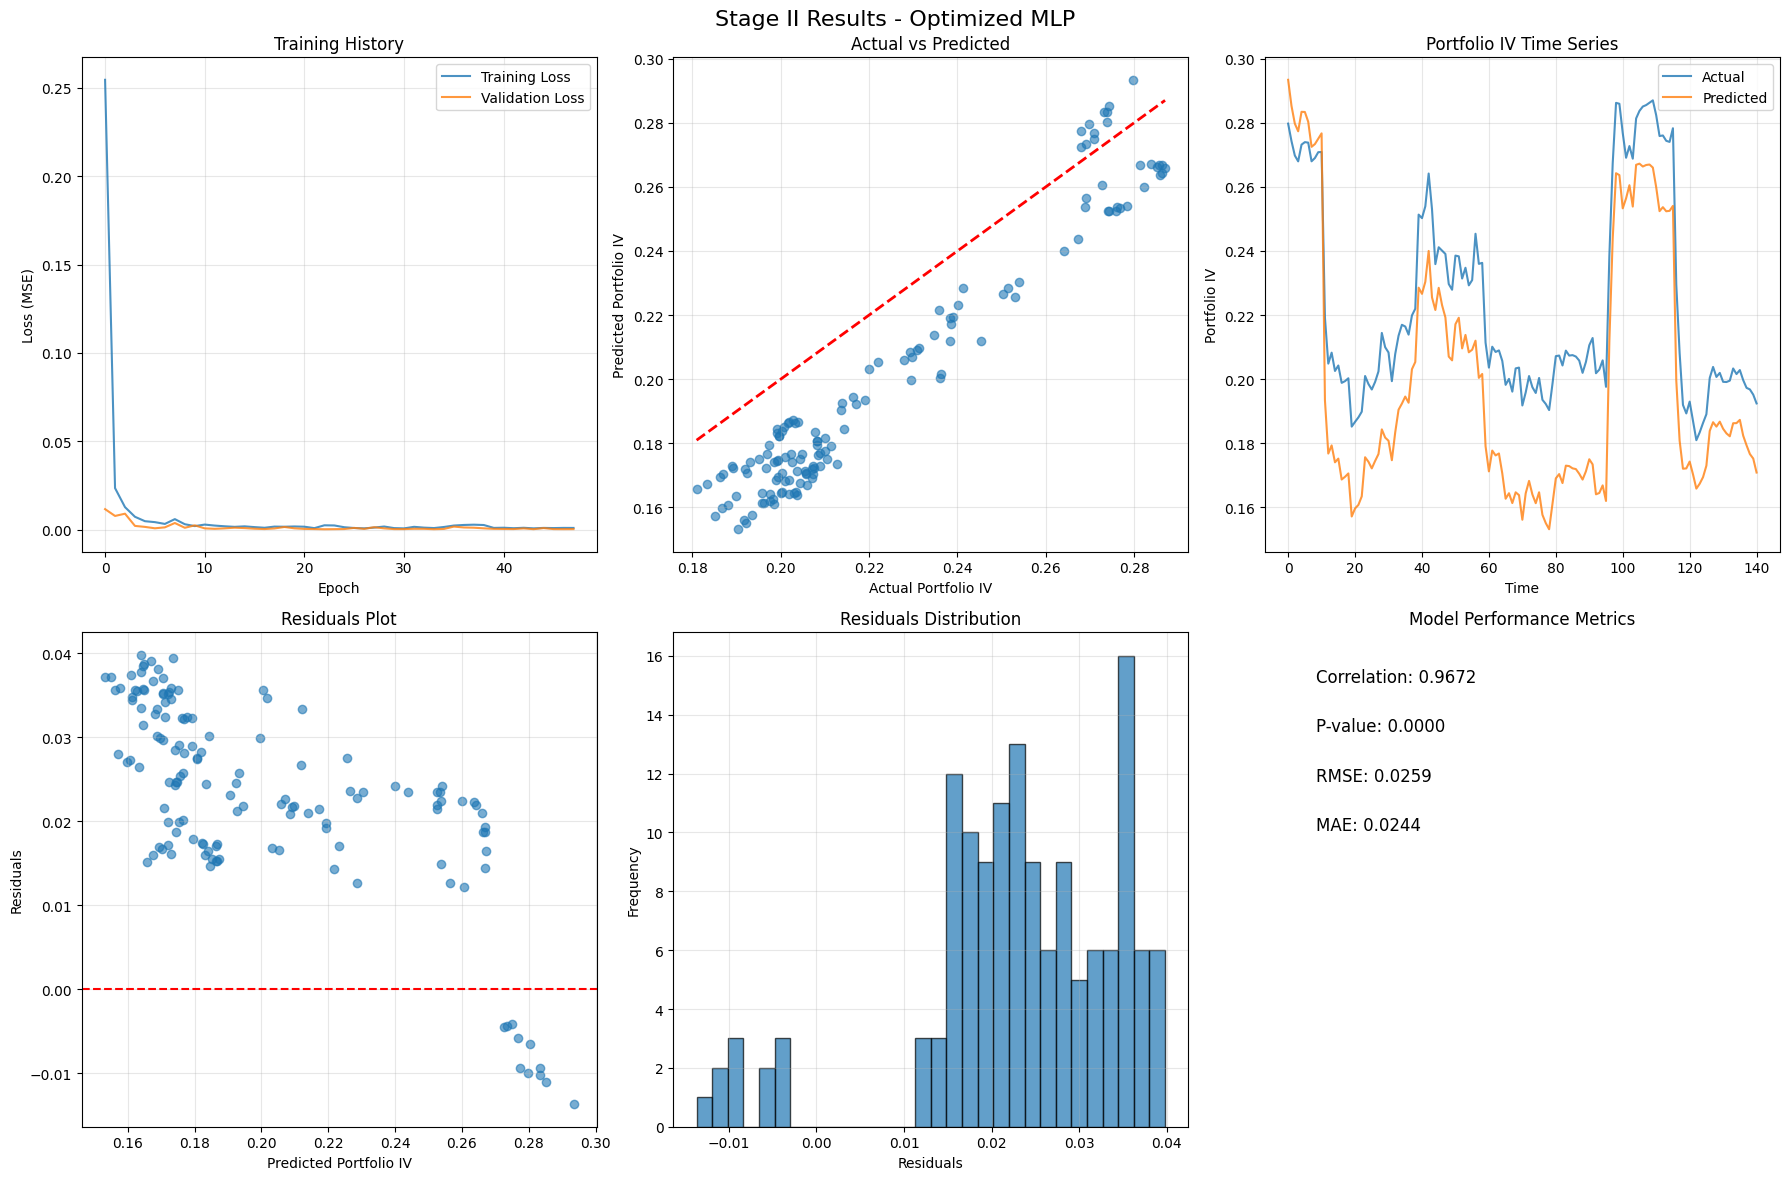


Stage I (Individual Stock IV) Results:
           RMSE       MAE
MSFT   0.040278  0.036420
NVDA   0.046087  0.031974
AAPL   0.043007  0.039990
AMZN   0.024110  0.013801
GOOGL  0.030030  0.013496

Stage II (Portfolio IV) Results:
          mse       mae      rmse correlation  \
MLP  0.000672  0.024382  0.025918    0.967175   

                           model_path  \
MLP  models/stage2/mlp_best_model.pth   

                                           best_params  
MLP  {'n_layers': 2, 'hidden_size_0': 128, 'hidden_...  

Complete results saved to 'results/complete_results.pkl'


In [16]:
# Stage 2: Portfolio IV Prediction
import sys
import os

print("Loading Stage I results...")
with open('results/stage1_results.pkl', 'rb') as f:
    stage1_data = pickle.load(f)

stage1_results = stage1_data['stage1_results']
individual_iv_predictions = stage1_data['individual_predictions']
stock_returns_data = stage1_data['stock_returns_data']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

os.makedirs('models/stage2', exist_ok=True)

portfolio_weights = [1.0/len(individual_iv_predictions)] * len(individual_iv_predictions)

print("\n" + "="*80)
print("STAGE II: PORTFOLIO IV PREDICTION")
print("="*80)

stage2_results = {}

if len(individual_iv_predictions) >= 2:

    if stock_returns_data:
        # Explicitly concatenate DataFrames from the dictionary
        returns_df = pd.concat(stock_returns_data.values(), axis=1, keys=stock_returns_data.keys())
        returns_df = returns_df.dropna()

        correlation_matrices, correlation_dates = calculate_correlation_matrix(returns_df, window=60)
        print(f"Calculated {len(correlation_matrices)} correlation matrices")

    else:
        print("No stock return data available for correlation calculation. Skipping Stage II.")
        sys.exit()

    try:
        # Removed market data download and processing
        market_data = None # Set market_data to None as it's no longer used in create_portfolio_features
        print("Market data download and processing skipped as per requirements.")

    except:
        market_data = None
        print("Market data not available")


    print("Creating portfolio features...")
    # Removed market_data from create_portfolio_features call
    portfolio_features, common_dates = create_portfolio_features(
        individual_iv_predictions,
        portfolio_weights,
        correlation_matrices,
        correlation_dates
    )

    print("Calculating portfolio IV targets...")
    # Removed market_data from calculate_portfolio_iv_target call
    portfolio_targets, target_dates = calculate_portfolio_iv_target(
        individual_iv_predictions,
        portfolio_weights,
        correlation_matrices,
        correlation_dates
    )

    common_feature_target_dates = pd.Index(common_dates).intersection(target_dates)
    common_feature_target_dates = common_feature_target_dates.sort_values()

    aligned_portfolio_features = []
    aligned_portfolio_targets = []

    portfolio_features_df = pd.DataFrame(portfolio_features, index=common_dates)
    portfolio_targets_series = pd.Series(portfolio_targets, index=target_dates)

    for date in common_feature_target_dates:
        aligned_portfolio_features.append(portfolio_features_df.loc[date].values)
        aligned_portfolio_targets.append(portfolio_targets_series.loc[date])

    aligned_portfolio_features = np.array(aligned_portfolio_features)
    aligned_portfolio_targets = np.array(aligned_portfolio_targets)

    print(f"Portfolio dataset size: {len(aligned_portfolio_features)} samples")
    print(f"Feature dimension: {aligned_portfolio_features.shape[1]}")

    if len(aligned_portfolio_features) == 0:
        print("No aligned portfolio data available for Stage II. Exiting.")
        sys.exit()

    train_size = int(0.7 * len(aligned_portfolio_features))
    val_size = int(0.15 * len(aligned_portfolio_features))

    X_train_p2 = aligned_portfolio_features[:train_size]
    y_train_p2 = aligned_portfolio_targets[:train_size]
    X_val_p2 = aligned_portfolio_features[train_size:train_size+val_size]
    y_val_p2 = aligned_portfolio_targets[train_size:train_size+val_size]
    X_test_p2 = aligned_portfolio_features[train_size+val_size:]
    y_test_p2 = aligned_portfolio_targets[train_size+val_size:]

    portfolio_scaler = StandardScaler()
    X_train_p2_scaled = portfolio_scaler.fit_transform(X_train_p2)
    X_val_p2_scaled = portfolio_scaler.transform(X_val_p2)
    X_test_p2_scaled = portfolio_scaler.transform(X_test_p2)

    print("\nOptimizing MLP hyperparameters...")
    best_mlp_params = optimize_mlp_hyperparameters(
        X_train_p2_scaled, y_train_p2, X_val_p2_scaled, y_val_p2, device, n_trials=20
    )

    print("\nTraining optimized MLP Model...")

    hidden_sizes = []
    for i in range(best_mlp_params['n_layers']):
        hidden_sizes.append(best_mlp_params[f'hidden_size_{i}'])

    mlp_model = PortfolioMLPModel(
        input_size=X_train_p2_scaled.shape[1],
        hidden_sizes=hidden_sizes,
        dropout_rate=best_mlp_params['dropout_rate']
    ).to(device)

    train_dataset_p2 = PortfolioDataset(X_train_p2_scaled, y_train_p2)
    val_dataset_p2 = PortfolioDataset(X_val_p2_scaled, y_val_p2)
    test_dataset_p2 = PortfolioDataset(X_test_p2_scaled, y_test_p2)

    train_loader_p2 = DataLoader(train_dataset_p2, batch_size=best_mlp_params['batch_size'], shuffle=True)
    val_loader_p2 = DataLoader(val_dataset_p2, batch_size=best_mlp_params['batch_size'], shuffle=False)
    test_loader_p2 = DataLoader(test_dataset_p2, batch_size=best_mlp_params['batch_size'], shuffle=False)

    mlp_train_losses, mlp_val_losses, _ = train_portfolio_model(
        mlp_model, train_loader_p2, val_loader_p2, 200, best_mlp_params['learning_rate'], device
    )

    mlp_model_path = 'models/stage2/mlp_best_model.pth'
    save_model(
        mlp_model,
        mlp_model_path,
        scalers=portfolio_scaler,
        metadata={
            'model_type': 'MLP',
            'best_params': best_mlp_params,
            'input_size': X_train_p2_scaled.shape[1],
            'hidden_sizes': hidden_sizes,
            'train_size': train_size,
            'val_size': val_size,
            'test_size': len(X_test_p2)
        }
    )

    mlp_model.eval()
    mlp_predictions_list = []
    mlp_actuals_list = []

    with torch.no_grad():
        for features, targets in test_loader_p2:
            features = features.to(device)
            outputs = mlp_model(features)
            print(f"Shape of outputs: {outputs.shape}")
            numpy_outputs = outputs.cpu().numpy()
            print(f"Shape of numpy_outputs: {numpy_outputs.shape}")
            mlp_predictions_list.append(numpy_outputs)
            mlp_actuals_list.append(targets.cpu().numpy())

    mlp_predictions = np.concatenate(mlp_predictions_list).flatten()
    mlp_actuals = np.concatenate(mlp_actuals_list).flatten()


    print(f"Length of mlp_actuals: {len(mlp_actuals)}")
    print(f"Length of mlp_predictions: {len(mlp_predictions)}")


    mlp_mse = mean_squared_error(mlp_actuals, mlp_predictions)
    mlp_mae = mean_absolute_error(mlp_actuals, mlp_predictions)
    mlp_rmse = np.sqrt(mlp_mse)
    mlp_corr, _ = pearsonr(mlp_actuals, mlp_predictions)

    stage2_results['MLP'] = {
        'mse': mlp_mse, 'mae': mlp_mae, 'rmse': mlp_rmse, 'correlation': mlp_corr,
        'model_path': mlp_model_path, 'best_params': best_mlp_params
    }

    print(f"MLP Results - RMSE: {mlp_rmse:.6f}, MAE: {mlp_mae:.6f}, Correlation: {mlp_corr:.4f}")

    plot_stage2_results(mlp_train_losses, mlp_val_losses, mlp_actuals, mlp_predictions, "Optimized MLP")

    print("\nStage I (Individual Stock IV) Results:")
    stage1_df = pd.DataFrame({
        ticker: {
            'RMSE': stage1_results[ticker]['rmse'],
            'MAE': stage1_results[ticker]['mae']
        } for ticker in stage1_results.keys()
    }).T
    print(stage1_df)

    print("\nStage II (Portfolio IV) Results:")
    stage2_df = pd.DataFrame(stage2_results).T
    print(stage2_df)

    with open('results/complete_results.pkl', 'wb') as f:
        pickle.dump({
            'stage1_results': stage1_results,
            'stage2_results': stage2_results,
            'individual_predictions': individual_iv_predictions,
            'portfolio_features': aligned_portfolio_features,
            'portfolio_targets': aligned_portfolio_targets,
            'portfolio_scaler': portfolio_scaler
        }, f)

    print("\nComplete results saved to 'results/complete_results.pkl'")

else:
    print("Not enough individual predictions for Stage II")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

After running the above cell and following the authorization steps, your Google Drive will be mounted at `/content/drive`. You can then save the results file to a specific folder in your Drive, for example:

In [ ]:
import shutil

source_path = 'results/stage1_results.pkl'
destination_path = '/content/drive/MyDrive/your_folder_name/stage1_results.pkl'

import os
os.makedirs(os.path.dirname(destination_path), exist_ok=True)

shutil.copy(source_path, destination_path)

print(f"Results saved to {destination_path}")

In [ ]:
import pickle
from google.colab import drive
import os

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted.")

saved_file_path = '/content/drive/MyDrive/your_folder_name/stage1_results.pkl'

try:
    with open(saved_file_path, 'rb') as f:
        loaded_stage1_data = pickle.load(f)

    loaded_stage1_results = loaded_stage1_data['stage1_results']
    loaded_individual_predictions = loaded_stage1_data['individual_predictions']

    print(f"Successfully loaded data from {saved_file_path}")
    print(f"Number of stocks in loaded results: {len(loaded_stage1_results)}")

except FileNotFoundError:
    print(f"Error: File not found at {saved_file_path}. Please check the folder name and file path.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")

In [ ]:
import pickle
import os

saved_file_path = '/content/drive/MyDrive/your_results_folder/two_stage_results.pkl'

try:
    with open(saved_file_path, 'rb') as f:
        loaded_data = pickle.load(f)

    loaded_stage1_results = loaded_data['stage1_results']
    loaded_stage2_results = loaded_data['stage2_results']
    loaded_individual_predictions = loaded_data['individual_predictions']

    print(f"Successfully loaded data from {saved_file_path}")

except FileNotFoundError:
    print(f"Error: File not found at {saved_file_path}.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")

In [9]:
print(stock_returns_data)

{'MSFT': Ticker          MSFT
Date                
2020-01-03 -0.012530
2020-01-06  0.002582
2020-01-07 -0.009159
2020-01-08  0.015803
2020-01-09  0.012415
...              ...
2023-12-22  0.002780
2023-12-26  0.000214
2023-12-27 -0.001576
2023-12-28  0.003229
2023-12-29  0.002023

[1005 rows x 1 columns], 'NVDA': Ticker          NVDA
Date                
2020-01-03 -0.016136
2020-01-06  0.004185
2020-01-07  0.012034
2020-01-08  0.001874
2020-01-09  0.010923
...              ...
2023-12-22 -0.003271
2023-12-26  0.009153
2023-12-27  0.002796
2023-12-28  0.002123
2023-12-29  0.000000

[1005 rows x 1 columns], 'AAPL': Ticker          AAPL
Date                
2020-01-03 -0.009769
2020-01-06  0.007937
2020-01-07 -0.004714
2020-01-08  0.015958
2020-01-09  0.021019
...              ...
2023-12-22 -0.005563
2023-12-26 -0.002845
2023-12-27  0.000518
2023-12-28  0.002224
2023-12-29 -0.005439

[1005 rows x 1 columns], 'AMZN': Ticker          AMZN
Date                
2020-01-03 -0.012213
2020-01